<a href="https://colab.research.google.com/github/nrajmalwar/Project/blob/master/Session%2019/Assignment_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
# example of a dcgan on guns dataset
import numpy
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

import cv2
from PIL import Image
from google.colab import files
import os
from os import listdir
from PIL import Image
import os, sys

Using TensorFlow backend.


# Image Preprocessing

In [0]:
# Import and unzip the the dataset
!unzip -q "/content/drive/My Drive/Colab Notebooks/EVA/Session 19/Guns_dataset.zip"

In [0]:
# Directory to store resized images
!mkdir 'Guns_resized'
new_path = 'Guns_resized'

# Directory to original size images
path = "Guns_dataset"
dirs = os.listdir(path)

In [0]:
image_width = 64
image_height = 64
image_channels = 3

# Resize the images to 64x64 using bicubic interpolation
for item in dirs:
  if os.path.isfile(path + '/' + item):
    im = Image.open(path + '/' + item)
    imResize = im.resize((image_width, image_height))
    imResize.save(new_path + '/' + item, 'JPEG')

In [0]:
# Store the resized images to a separate directory
!zip -r /content/Guns_resized.zip /content/Guns_resized

files.download('Guns_resized.zip')

In [0]:
dirs_new = os.listdir(new_path)

In [0]:
X_data = []

# Read the images from the folder and store it in a list
for item in dirs_new:
  if os.path.isfile(new_path + '/' + item):
    im = cv2.imread(new_path + '/' + item)
    X_data.append(im)

# Store the images in a numpy array
X = numpy.array(X_data)

In [7]:
# Print the shape of the training images
X.shape

(2296, 64, 64, 3)

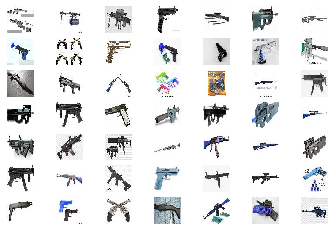

In [9]:
# Plot images for the real images

for i in range(49):
	# define subplot
	pyplot.subplot(7, 7, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(X[i])
  
filename = 'real_images.png'
pyplot.savefig(filename)

# GAN Functions

In [0]:
# define the standalone discriminator model

def define_discriminator(in_shape=(64,64,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64*2, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128*2, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128*2, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256*2, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [0]:
# define the standalone generator model

def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 8 * 8
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

In [0]:
# define the combined generator and discriminator model, for updating the generator

def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [0]:
# load and prepare guns training images

def load_real_samples():
	# convert from unsigned ints to floats
	X_train = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X_train = (X_train - 127.5) / 127.5
	return X_train

In [0]:
# select real samples

def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [0]:
# generate points in latent space as input for the generator

def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [0]:
# use the generator to generate n fake examples, with class labels

def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [0]:
# create and save a plot of generated images

def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [0]:
# evaluate the discriminator, plot generated images, save generator model

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

In [0]:
# train the generator and discriminator

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=400, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

# Model Training

In [43]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/17, d1=0.674, d2=0.696 g=0.692


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
>108, 13/17, d1=0.220, d2=0.099 g=4.263
>108, 14/17, d1=0.166, d2=0.192 g=3.909
>108, 15/17, d1=0.439, d2=0.465 g=5.070
>108, 16/17, d1=0.604, d2=0.075 g=3.387
>108, 17/17, d1=0.256, d2=0.368 g=3.548
>109, 1/17, d1=0.262, d2=0.133 g=3.895
>109, 2/17, d1=0.239, d2=0.156 g=3.534
>109, 3/17, d1=0.130, d2=0.140 g=3.680
>109, 4/17, d1=0.214, d2=0.176 g=3.832
>109, 5/17, d1=0.236, d2=0.114 g=3.697
>109, 6/17, d1=0.143, d2=0.141 g=3.055
>109, 7/17, d1=0.121, d2=0.330 g=3.762
>109, 8/17, d1=0.279, d2=0.105 g=3.467
>109, 9/17, d1=0.257, d2=0.907 g=4.328
>109, 10/17, d1=1.845, d2=3.186 g=5.492
>109, 11/17, d1=2.435, d2=0.211 g=2.281
>109, 12/17, d1=0.401, d2=0.886 g=3.168
>109, 13/17, d1=0.563, d2=0.141 g=3.009
>109, 14/17, d1=0.627, d2=0.461 g=2.437
>109, 15/17, d1=0.301, d2=0.233 g=2.806
>109, 16/17, d1=0.414, d2=0.305 g=2.699
>109, 17/17, d1=0.341, d2=0.244 g=2.604
>110, 1/17, d1=0.368, d2=0.301 g=2.697
>110, 2/17, d1=0.308, d2=0.279 g=2.866
